In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import nltk
import re
from sklearn import metrics

In [ ]:
# read file into pandas using a relative path
sms = pd.read_csv("spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

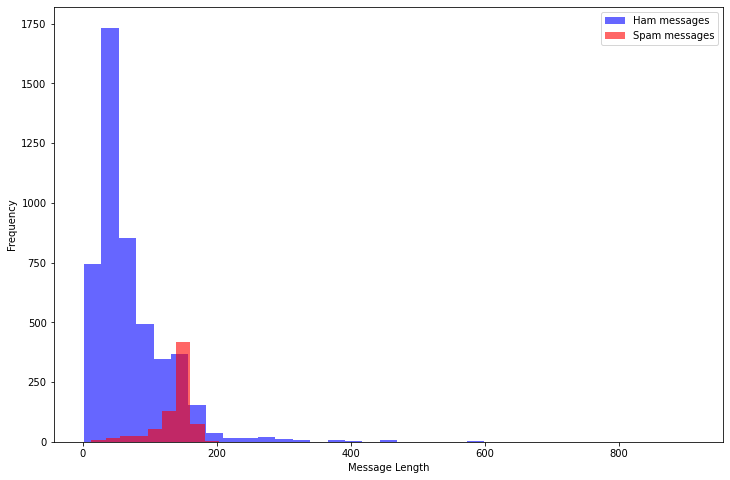

In [ ]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [ ]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
from nltk.corpus import stopwords
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS])

In [ ]:
sms['clean_msg'] = sms.message.apply(text_process)

In [ ]:
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think goes usf lives around though


In [ ]:
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


# Feature Creation: Bag-of-Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [ ]:
X_train_dtm = vect.transform(X_train)

In [ ]:
# Generate the number of words as a feature

X_train_word_count = X_train_dtm.A.sum(axis = 1)

X_train_word_count = X_train_word_count.reshape([X_train_word_count.shape[0],1])

In [ ]:
# combine with BoW matrix

from scipy.sparse import hstack

X_train_dtm = hstack([X_train_dtm,X_train_word_count])

In [ ]:
X_test_dtm = vect.transform(X_test)
X_test_word_count = X_test_dtm.A.sum(axis = 1)
X_test_word_count = X_test_word_count.reshape([X_test_word_count.shape[0],1])
X_test_dtm = hstack([X_test_dtm,X_test_word_count])
X_test_dtm

<1393x7997 sparse matrix of type '<class 'numpy.longlong'>'
	with 11352 stored elements in COOrdinate format>

# Model

## SVM

In [ ]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train_dtm, y_train)

SVC(probability=True)

In [ ]:
y_pred_class = svc.predict(X_test_dtm)
metrics.accuracy_score(y_test, y_pred_class)

0.9641062455132807

In [ ]:
y_pred_prob = svc.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9775808372263443